In [109]:
# import numpy as np
# import matplotlib.pyplot as plt

# def read_binary_file2d(filename):
#     # Read the binary file
#     with open(filename, 'rb') as file:
#         depth = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
#         rows = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
#         cols = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
        
#         data = np.fromfile(file, dtype=np.float32)
#         data = data.reshape((depth, rows, cols))

#     # Extract subbands
#     LL = data[:, :rows//2, :cols//2]
#     LH = data[:, :rows//2, cols//2:]
#     HL = data[:, rows//2:, :cols//2]
#     HH = data[:, rows//2:, cols//2:]

#     # Create a dictionary to store the subbands
#     subbands = {
#         'LL': LL,
#         'LH': LH,
#         'HL': HL,
#         'HH': HH
#     }

#     return subbands

# def normalize(data):
#     data = np.abs(data)
#     data = data / np.max(data)
#     return data

# def display_images(data, title, transform_type):
#     fig, axes = plt.subplots(1, 4, figsize=(20, 5))
#     fig.suptitle(title, fontsize=16)
    
#     keys = ['LL', 'LH', 'HL', 'HH']  # Explicit order
#     for i, key in enumerate(keys):
#         if key not in data:
#             print(f"Key '{key}' not found in data")
#             continue
#         # Get the first slice along the depth dimension
#         value = data[key][0]  # Display the first "depth" slice
#         value = normalize(value)  # Normalize the data
#         axes[i].imshow(value, cmap='gray')
#         axes[i].set_title(f'{transform_type} {key}')
#         axes[i].axis('off')
    
#     plt.show()

# # Read the binary file for 2D wavelet transform
# filename = '../Serial/outputs/3out.bin'
# data_2d = read_binary_file2d(filename)

# # Debug statement to print the keys of the data structure
# print("Keys in data_2d:", data_2d.keys())

# # Display the images for 2D wavelet transform
# display_images(data_2d, '2D Wavelet Transform', '2D')

In [110]:
# def check_energy_conservation(original_data, subbands):
#     original_energy = np.sum(original_data ** 2)
#     subbands_energy = sum(np.sum(subband ** 2) for subband in subbands.values())
#     print("")
#     print(f"Original energy: {original_energy}")
#     print(f"Subbands energy: {subbands_energy}")
#     if np.isclose(original_energy, subbands_energy, rtol=1e-5):
#         print("Energy is conserved.")
#     else:
#         print("Warning: Energy is not conserved.")


# def crop_to_match_shape(arr1, arr2):
#     """Crop the larger array to match the shape of the smaller array."""
#     min_depth = min(arr1.shape[0], arr2.shape[0])
#     min_rows = min(arr1.shape[1], arr2.shape[1])
#     min_cols = min(arr1.shape[2], arr2.shape[2])
#     return arr1[:min_depth, :min_rows, :min_cols], arr2[:min_depth, :min_rows, :min_cols]

Read dimensions from shape file: depth=78, rows=512, cols=512
Read data size: 20447232
Read dimensions from shape file: depth=78, rows=512, cols=512
Read data size: 20447232


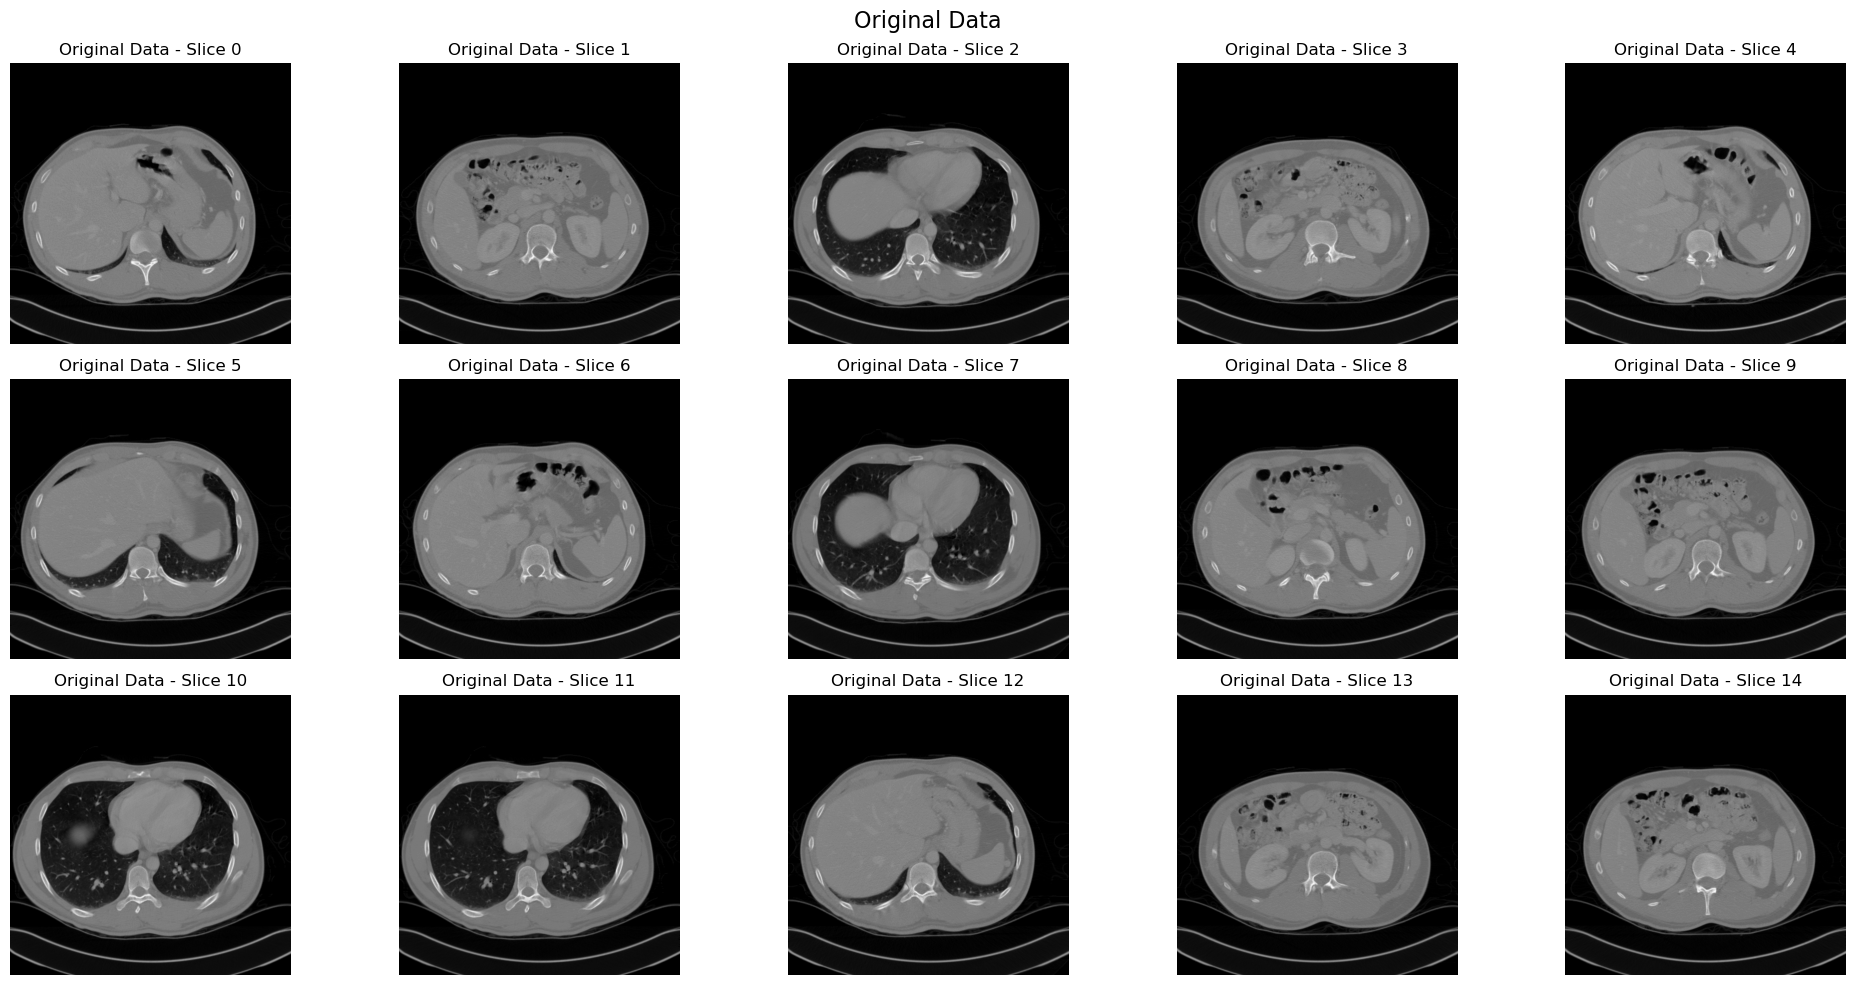

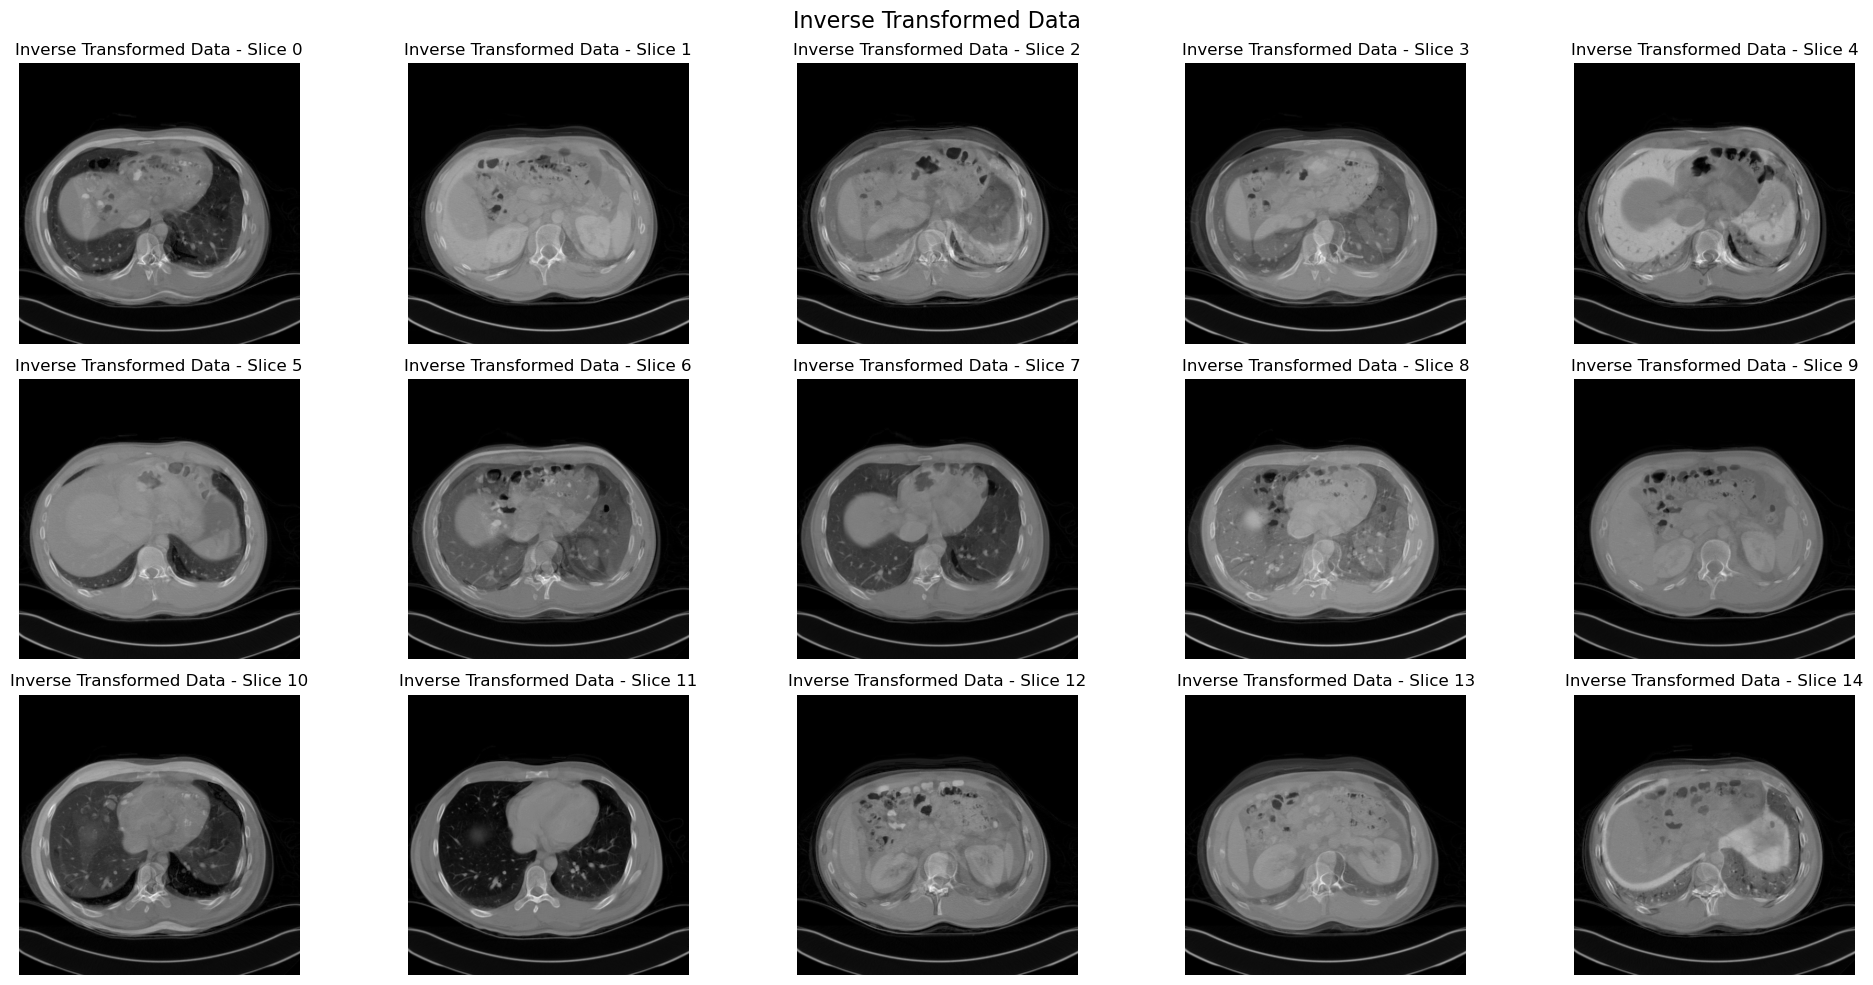

Mean Squared Error (MSE) between original and inverse data: 38187.3515625


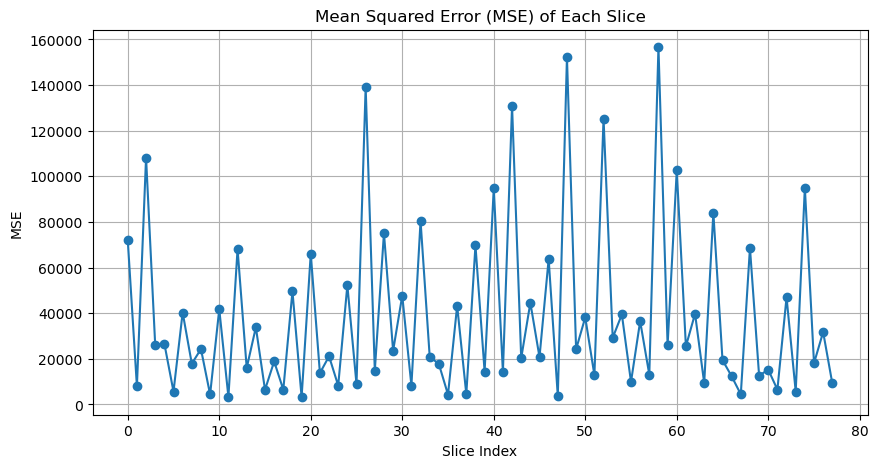

In [111]:
import numpy as np
import matplotlib.pyplot as plt

def read_shape_file(shape_filename):
    with open(shape_filename, 'r') as f:
        shape = tuple(map(int, f.read().strip().split(',')))
    return shape

def read_binary_file(filename, shape_filename):
    # Read the shape information
    depth, rows, cols = read_shape_file(shape_filename)
    print(f"Read dimensions from shape file: depth={depth}, rows={rows}, cols={cols}")
    
    # Read the binary file
    with open(filename, 'rb') as file:
        data = np.fromfile(file, dtype=np.float32)
        print(f"Read data size: {data.size}")
        
        data = data.reshape((depth, rows, cols))
        
    return data

def normalize(data):
    data = np.abs(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    return data

def display_slices(data, title, num_slices=15):
    fig, axes = plt.subplots(3, 5, figsize=(20, 10))
    fig.suptitle(title, fontsize=16)

    for i in range(num_slices):
        ax = axes[i // 5, i % 5]
        ax.imshow(normalize(data[i]), cmap='gray')
        ax.set_title(f'{title} - Slice {i}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_slice_mses(original_data, inverse_data):
    num_slices = original_data.shape[0]
    mses = [np.mean((original_data[i] - inverse_data[i]) ** 2) for i in range(num_slices)]
    
    plt.figure(figsize=(10, 5))
    plt.plot(mses, marker='o')
    plt.title('Mean Squared Error (MSE) of Each Slice')
    plt.xlabel('Slice Index')
    plt.ylabel('MSE')
    plt.grid(True)
    plt.show()

# Read the original input data
original_filename = '../../Final/data/3/3.bin'
shape_filename = '../../Final/data/3/3_shape.txt'
original_data = read_binary_file(original_filename, shape_filename)

# Read the inverse transformed data from the C++ implementation
inverse_cpp_filename = '../../Final/serial/outputs/3inverse.bin'
inverse_data = read_binary_file(inverse_cpp_filename, shape_filename)

# Display the first 15 slices of the original data
display_slices(original_data, 'Original Data', num_slices=15)

# Display the first 15 slices of the inverse transformed data
display_slices(inverse_data, 'Inverse Transformed Data', num_slices=15)

# Calculate and print the Mean Squared Error (MSE) between the original and inverse data
mse = np.mean((original_data - inverse_data) ** 2)
print(f"Mean Squared Error (MSE) between original and inverse data: {mse}")

# Plot the individual MSEs of each slice
plot_slice_mses(original_data, inverse_data)

Read dimensions from shape file: depth=78, rows=512, cols=512
Read data size: 20447232
Low-pass filter coefficients for db2: [-0.12940952255126037, 0.2241438680420134, 0.8365163037378079, 0.48296291314453416]
High-pass filter coefficients for db2: [-0.48296291314453416, 0.8365163037378079, -0.2241438680420134, -0.12940952255126037]


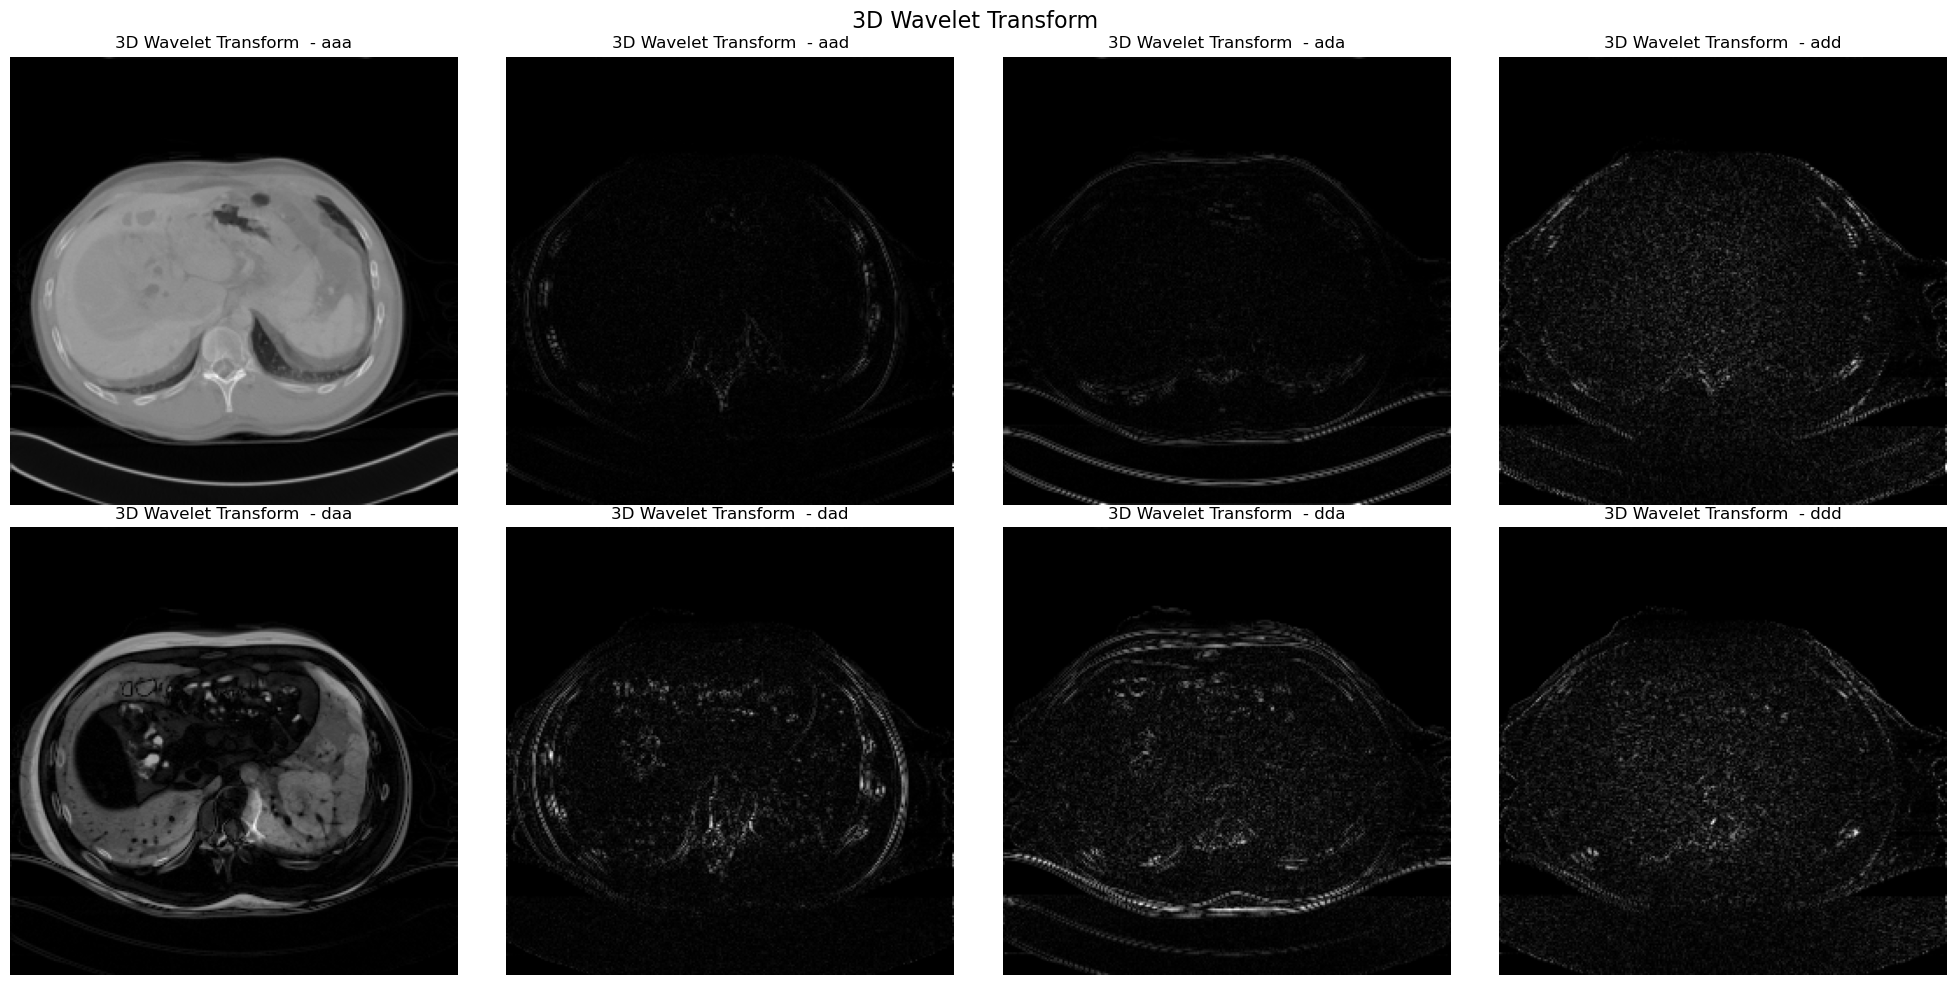

In [ ]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

def read_shape_file(shape_filename):
    with open(shape_filename, 'r') as f:
        shape = tuple(map(int, f.read().strip().split(',')))
    return shape

def read_binary_file(filename, shape_filename):
    # Read the shape information
    depth, rows, cols = read_shape_file(shape_filename)
    print(f"Read dimensions from shape file: depth={depth}, rows={rows}, cols={cols}")
    
    # Read the binary file
    with open(filename, 'rb') as file:
        data = np.fromfile(file, dtype=np.float32)
        print(f"Read data size: {data.size}")
        
        data = data.reshape((depth, rows, cols))
        
    return data

def read_wavelet3d_result(filename):
    subbands = {}
    with open(filename, 'rb') as file:
        for key in ['LLL', 'LLH', 'LHL', 'LHH', 'HLL', 'HLH', 'HHL', 'HHH']:
            depth = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
            rows = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
            cols = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
            data = np.fromfile(file, dtype=np.float32, count=depth*rows*cols)
            data = data.reshape((depth, rows, cols))
            subbands[key] = data
    return subbands

def normalize(data):
    data = np.abs(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    return data

def display_images(data, title, keys):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(title, fontsize=16)

    for i, key in enumerate(keys):
        if key not in data:
            print(f"Key '{key}' not found in data")
            continue
        # Get the first slice along the depth dimension
        value = data[key][0]  # Display the first "depth" slice
        value = normalize(value)
        ax = axes[i // 4, i % 4]
        ax.imshow(value, cmap='gray')
        ax.set_title(f'{title} - {key}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

def display_images1(data, title, keys):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(title, fontsize=16)

    for i, key in enumerate(keys):
        if key not in data:
            print(f"Key '{key}' not found in data")
            continue
        # Get the first slice along the depth dimension
        value = data[key][0]  # Display the first "depth" slice
        value = normalize(value)
        ax = axes[i // 4, i % 4]
        ax.imshow(value, cmap='gray')
        ax.set_title(f'{title} - {key}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


def perform_3d_wavelet_transform_pywt(data, wavelet, mode):
    coeffs = pywt.dwtn(data, wavelet=wavelet, mode=mode)
    return coeffs

wavelet_name = 'db2'  # Change this to any wavelet filter you want to use

# Read the original input data
original_filename = '../../Final/data/3/3.bin'
shape_filename = '../../Final/data/3/3_shape.txt'
original_data = read_binary_file(original_filename, shape_filename)

# Print filter coefficients
wavelet = pywt.Wavelet(wavelet_name)
print(f"Low-pass filter coefficients for {wavelet_name}: {wavelet.dec_lo}")
print(f"High-pass filter coefficients for {wavelet_name}: {wavelet.dec_hi}")

# Allow user to specify the wavelet filter

coeffs_pywt = perform_3d_wavelet_transform_pywt(original_data, wavelet=wavelet_name, mode='periodization')


# Read the results from the C++ implementation
cpp_filename = '../../Final/serial/outputs/3out.bin'
data_cpp = read_wavelet3d_result(cpp_filename)

# Display the images for 3D wavelet transform using PyWavelets
display_images(coeffs_pywt, '3D Wavelet Transform ', keys=['aaa', 'aad', 'ada', 'add', 'daa', 'dad', 'dda', 'ddd'])

# Display the images for 3D wavelet transform from C++ implementation
display_images1(data_cpp, '3D Wavelet Transform', keys=['LLL', 'LLH', 'LHL', 'LHH', 'HLL', 'HLH', 'HHL', 'HHH'])

# Mapping between C++ keys and PyWavelets keys
cpp_to_pywt_keys = {
    'LLL': 'aaa', 'LLH': 'aad', 'LHL': 'ada', 'LHH': 'add',
    'HLL': 'daa', 'HLH': 'dad', 'HHL': 'dda', 'HHH': 'ddd'
}

# Compare the results with corrected key mapping
for cpp_key, pywt_key in cpp_to_pywt_keys.items():
    try:
        cpp_data, pywt_data = data_cpp[cpp_key], coeffs_pywt[pywt_key]
        mse = np.mean((cpp_data - pywt_data) ** 2)
        euclidean_distance = np.linalg.norm(cpp_data - pywt_data)
        print(f"MSE for {cpp_key}: {mse}")
        print(f"Euclidean distance for {cpp_key}: {euclidean_distance}")
        print("")
    except KeyError as e:
        print(f"KeyError: {e} for key {cpp_key}")

In [ ]:
for key, value in coeffs_pywt.items():
    print(f"Resolution of subband {key}: {value.shape}")

Resolution of subband aaa: (39, 256, 256)
Resolution of subband aad: (39, 256, 256)
Resolution of subband ada: (39, 256, 256)
Resolution of subband add: (39, 256, 256)
Resolution of subband daa: (39, 256, 256)
Resolution of subband dad: (39, 256, 256)
Resolution of subband dda: (39, 256, 256)
Resolution of subband ddd: (39, 256, 256)


In [ ]:
for key, value in data_cpp.items():
    print(f"Resolution of subband {key}: {value.shape}")

Resolution of subband LLL: (39, 256, 256)
Resolution of subband LLH: (39, 256, 256)
Resolution of subband LHL: (39, 256, 256)
Resolution of subband LHH: (39, 256, 256)
Resolution of subband HLL: (39, 256, 256)
Resolution of subband HLH: (39, 256, 256)
Resolution of subband HHL: (39, 256, 256)
Resolution of subband HHH: (39, 256, 256)


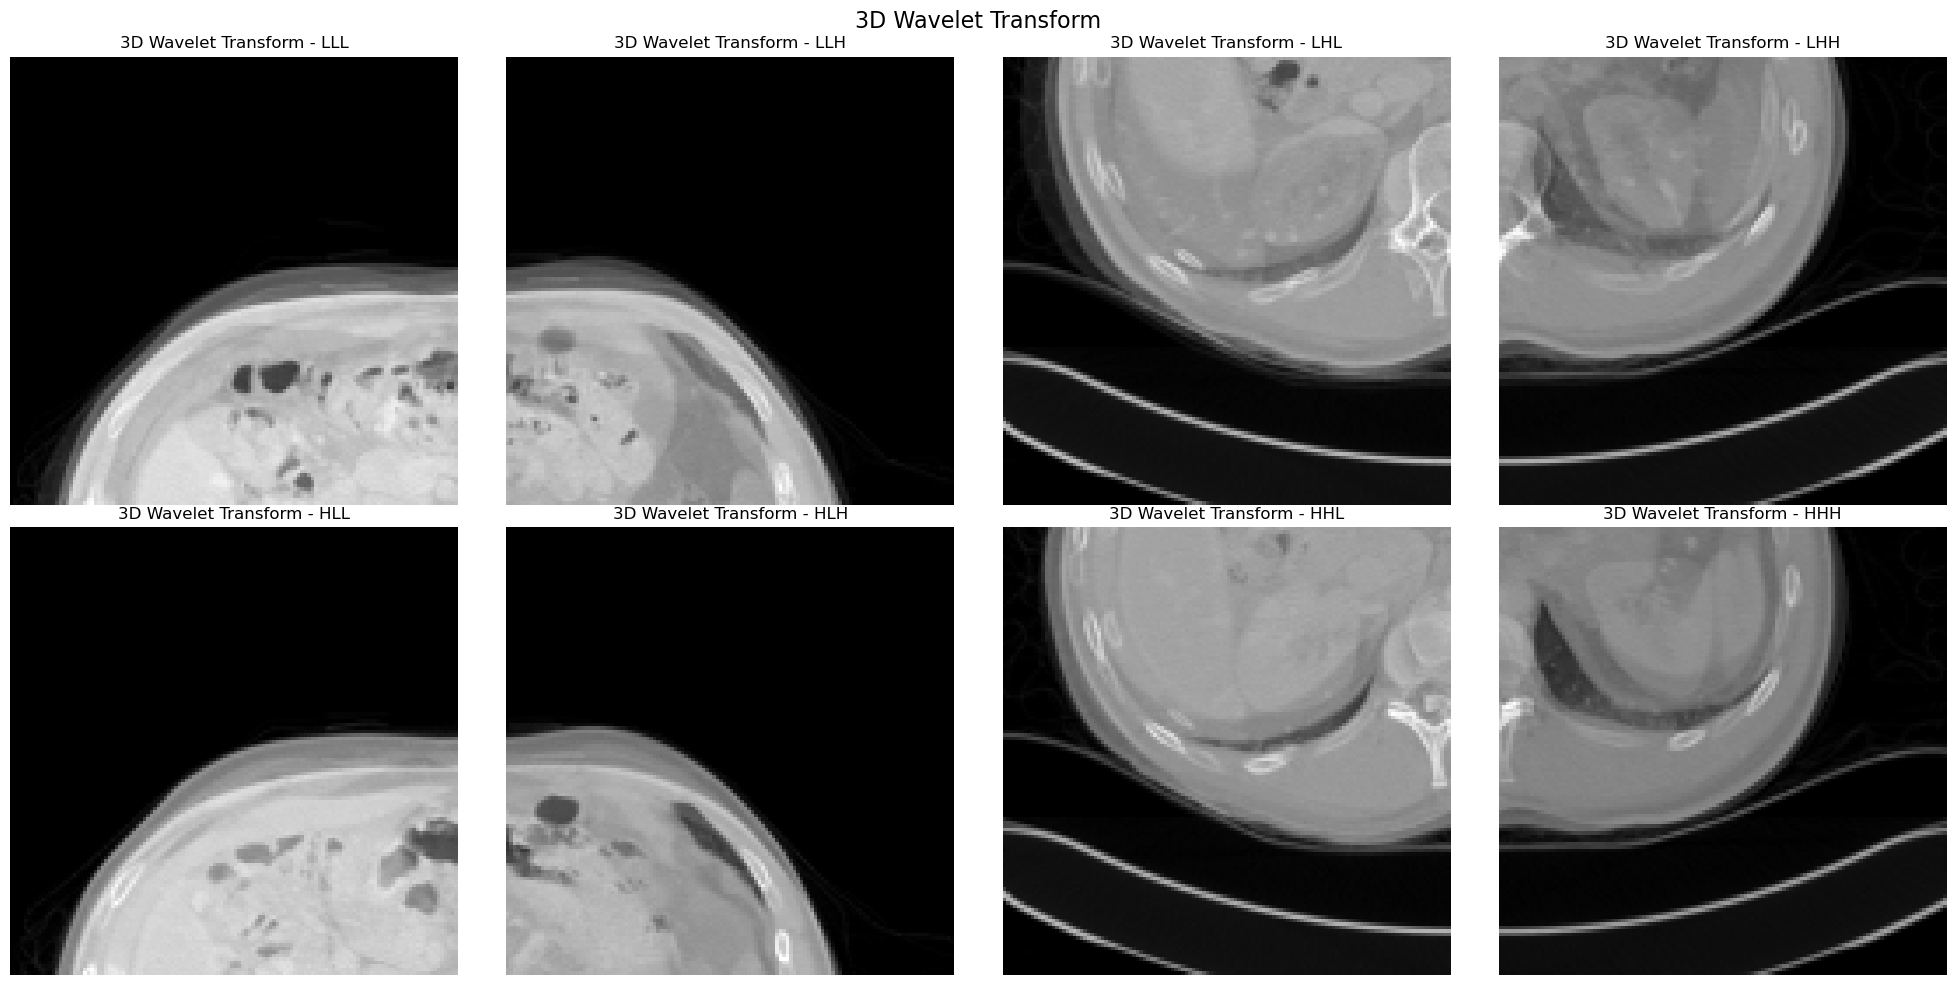

In [ ]:
# Extract the LLL subband from the first level
LLL_subband = data_cpp['LLL']

# Get the dimensions of the LLL subband
depth, rows, cols = LLL_subband.shape

# Use ceil to handle odd dimensions correctly
half_depth = int(np.ceil(depth / 2))
half_rows = int(np.ceil(rows / 2))
half_cols = int(np.ceil(cols / 2))

# Extract the subbands from the second level LLL subband
subbands_level2 = {
    'LLL': LLL_subband[:half_depth, :half_rows, :half_cols],
    'LLH': LLL_subband[:half_depth, :half_rows, half_cols:],
    'LHL': LLL_subband[:half_depth, half_rows:, :half_cols],
    'LHH': LLL_subband[:half_depth, half_rows:, half_cols:],
    'HLL': LLL_subband[half_depth:, :half_rows, :half_cols],
    'HLH': LLL_subband[half_depth:, :half_rows, half_cols:],
    'HHL': LLL_subband[half_depth:, half_rows:, :half_cols],
    'HHH': LLL_subband[half_depth:, half_rows:, half_cols:]
}

# Display the images for the second level wavelet transform
display_images(subbands_level2, '3D Wavelet Transform', keys=['LLL', 'LLH', 'LHL', 'LHH', 'HLL', 'HLH', 'HHL', 'HHH'])

In [ ]:
for key, value in subbands_level2.items():
    print(f"Resolution of subband {key}: {value.shape}")

Resolution of subband LLL: (20, 128, 128)
Resolution of subband LLH: (20, 128, 128)
Resolution of subband LHL: (20, 128, 128)
Resolution of subband LHH: (20, 128, 128)
Resolution of subband HLL: (19, 128, 128)
Resolution of subband HLH: (19, 128, 128)
Resolution of subband HHL: (19, 128, 128)
Resolution of subband HHH: (19, 128, 128)


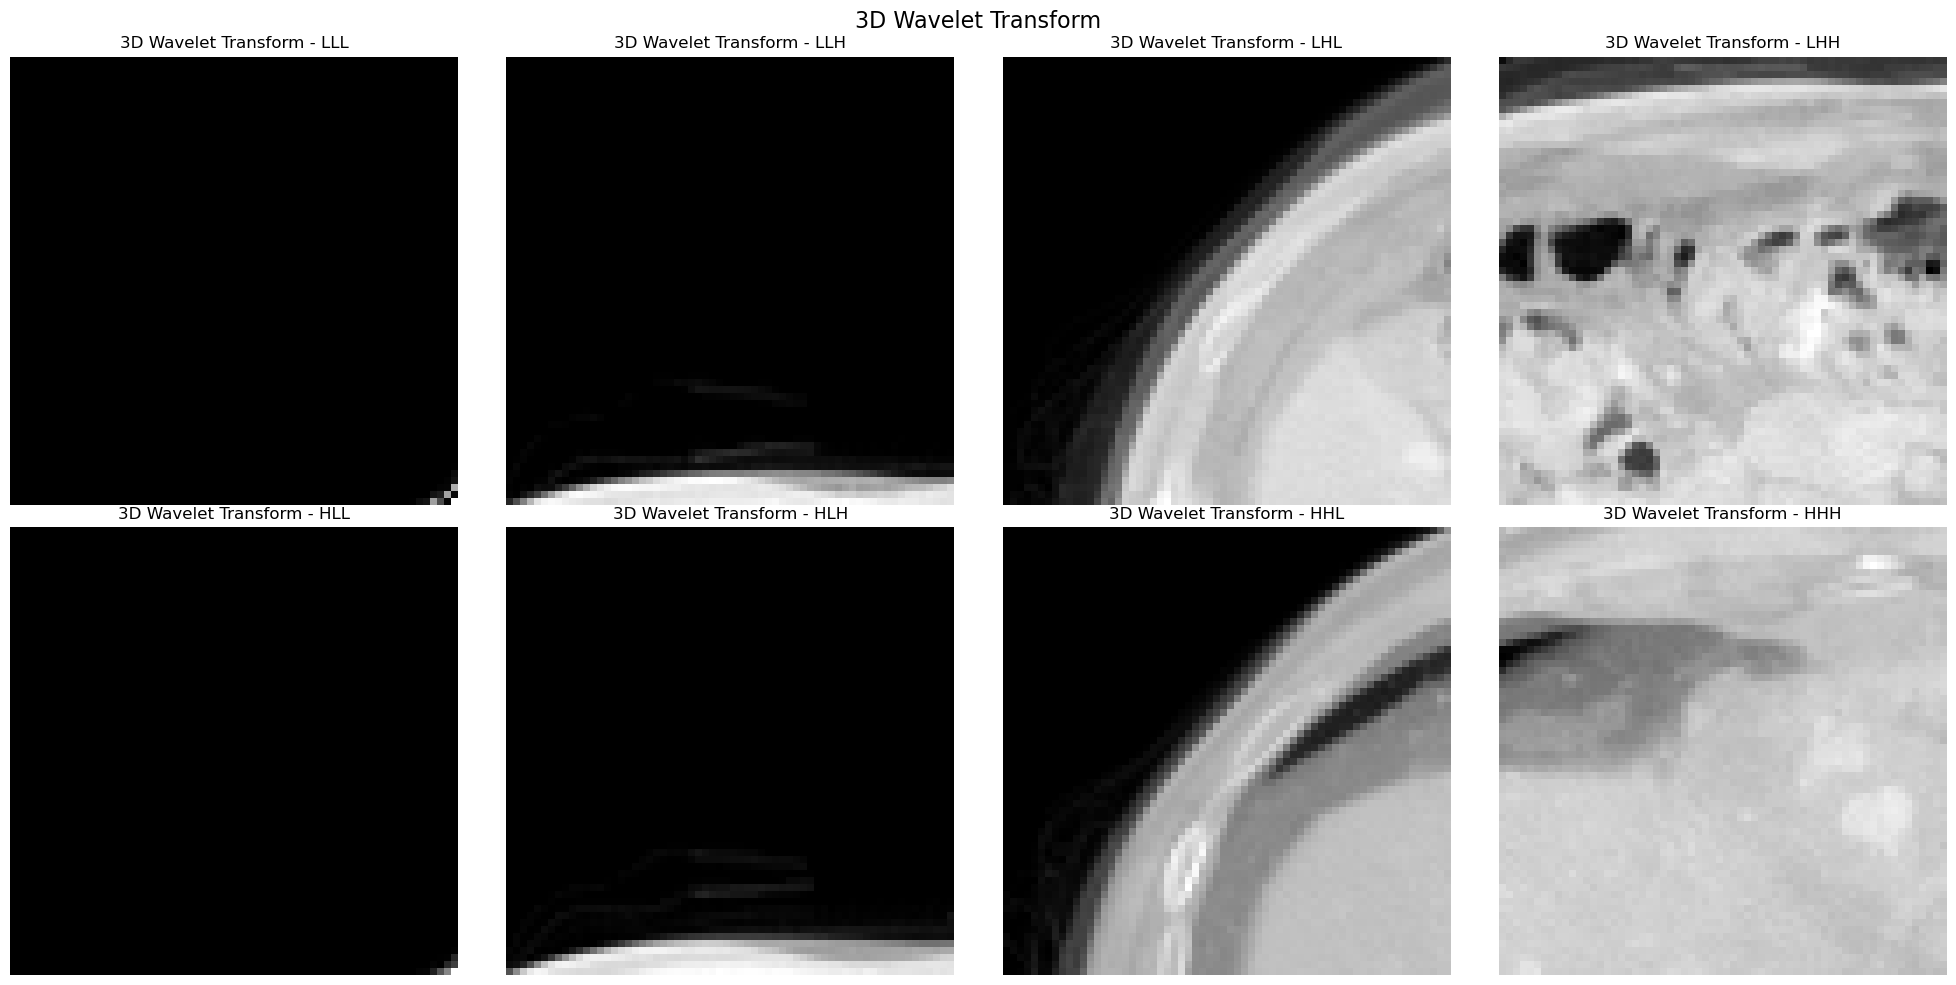

In [ ]:
# Extract the LLL subband from the first level
LLL_subband1 = subbands_level2['LLL']

# Get the dimensions of the LLL subband
depth, rows, cols = LLL_subband1.shape

# Use ceil to handle odd dimensions correctly
half_depth = int(np.ceil(depth / 2))
half_rows = int(np.ceil(rows / 2))
half_cols = int(np.ceil(cols / 2))

# Extract the subbands from the second level LLL subband
subbands_level3 = {
    'LLL': LLL_subband1[:half_depth, :half_rows, :half_cols],
    'LLH': LLL_subband1[:half_depth, :half_rows, half_cols:],
    'LHL': LLL_subband1[:half_depth, half_rows:, :half_cols],
    'LHH': LLL_subband1[:half_depth, half_rows:, half_cols:],
    'HLL': LLL_subband1[half_depth:, :half_rows, :half_cols],
    'HLH': LLL_subband1[half_depth:, :half_rows, half_cols:],
    'HHL': LLL_subband1[half_depth:, half_rows:, :half_cols],
    'HHH': LLL_subband1[half_depth:, half_rows:, half_cols:]
}

# Display the images for the second level wavelet transform
display_images(subbands_level3, '3D Wavelet Transform', keys=['LLL', 'LLH', 'LHL', 'LHH', 'HLL', 'HLH', 'HHL', 'HHH'])

In [ ]:
for key, value in subbands_level3.items():
    print(f"Resolution of subband {key}: {value.shape}")

Resolution of subband LLL: (10, 64, 64)
Resolution of subband LLH: (10, 64, 64)
Resolution of subband LHL: (10, 64, 64)
Resolution of subband LHH: (10, 64, 64)
Resolution of subband HLL: (10, 64, 64)
Resolution of subband HLH: (10, 64, 64)
Resolution of subband HHL: (10, 64, 64)
Resolution of subband HHH: (10, 64, 64)


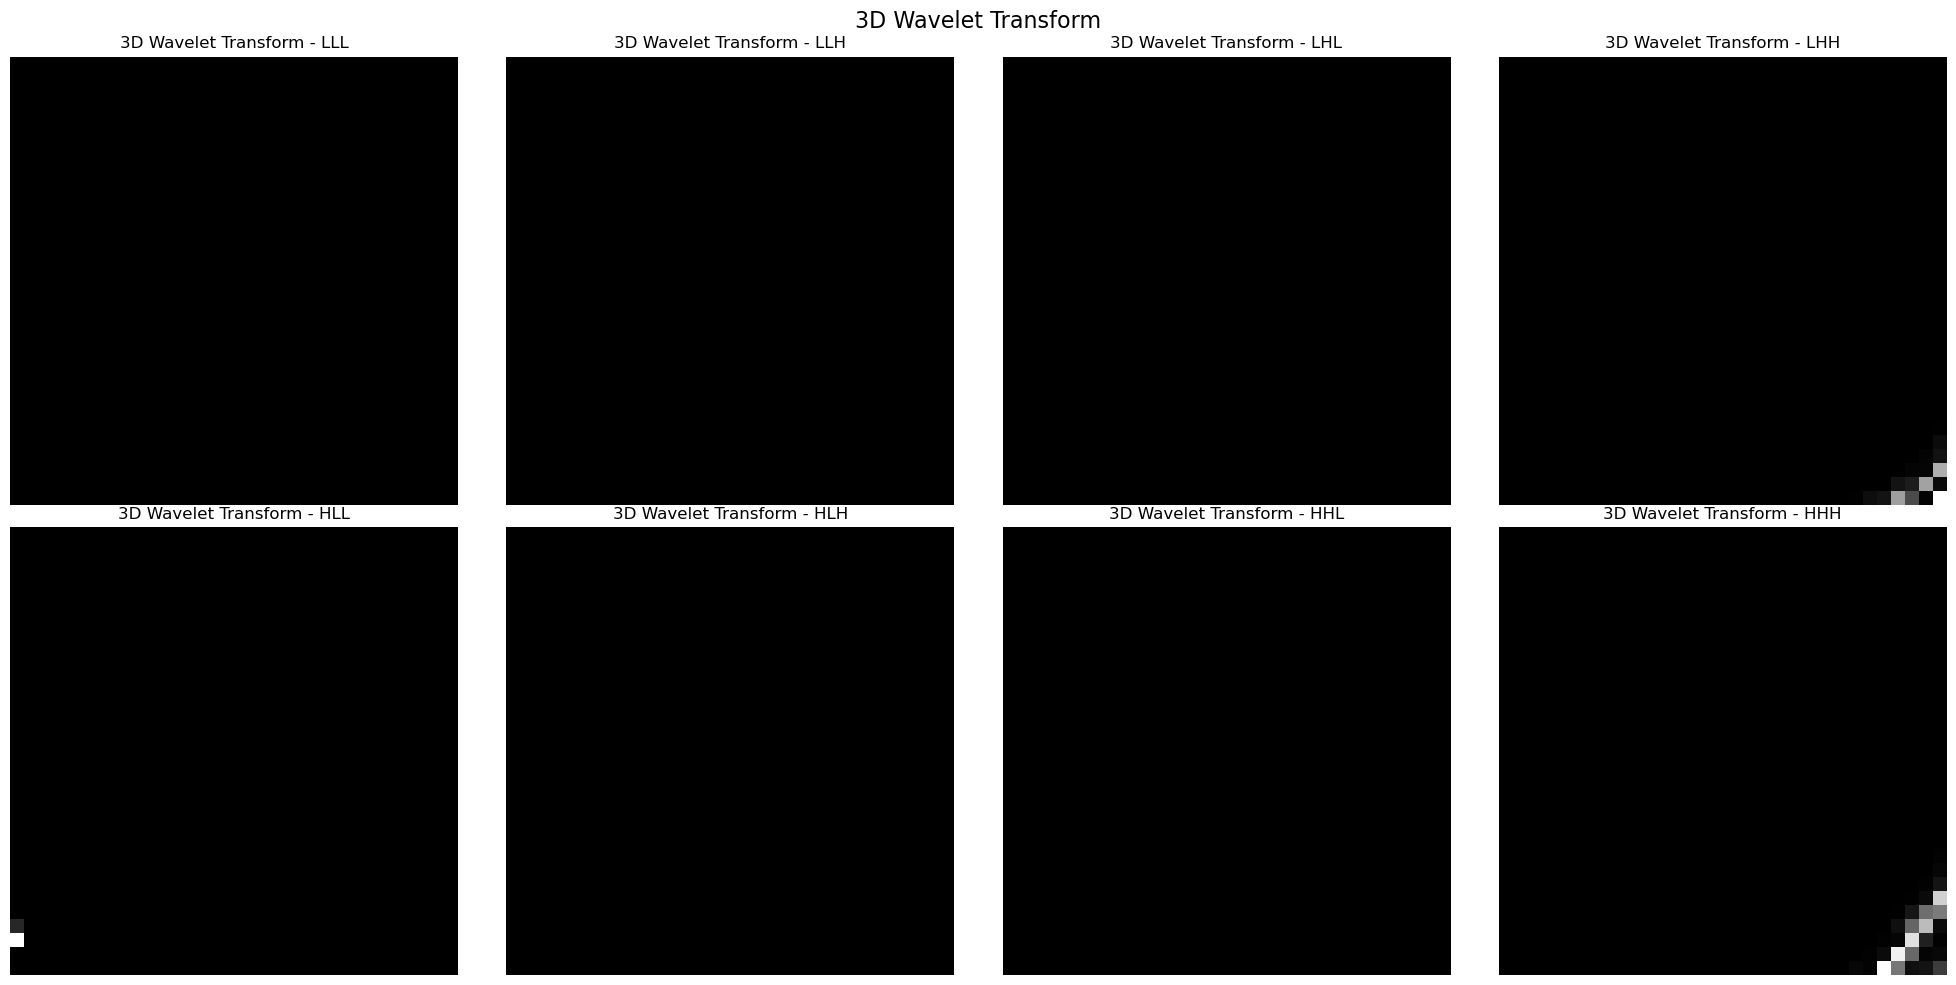

In [ ]:
# Extract the LLL subband from the first level
LLL_subband2 = subbands_level3['LLL']

# Get the dimensions of the LLL subband
depth, rows, cols = LLL_subband2.shape

# Use ceil to handle odd dimensions correctly
half_depth = int(np.ceil(depth / 2))
half_rows = int(np.ceil(rows / 2))
half_cols = int(np.ceil(cols / 2))

# Extract the subbands from the second level LLL subband
subbands_level4 = {
    'LLL': LLL_subband2[:half_depth, :half_rows, :half_cols],
    'LLH': LLL_subband2[:half_depth, :half_rows, half_cols:],
    'LHL': LLL_subband2[:half_depth, half_rows:, :half_cols],
    'LHH': LLL_subband2[:half_depth, half_rows:, half_cols:],
    'HLL': LLL_subband2[half_depth:, :half_rows, :half_cols],
    'HLH': LLL_subband2[half_depth:, :half_rows, half_cols:],
    'HHL': LLL_subband2[half_depth:, half_rows:, :half_cols],
    'HHH': LLL_subband2[half_depth:, half_rows:, half_cols:]
}

# Display the images for the second level wavelet transform
display_images(subbands_level4, '3D Wavelet Transform', keys=['LLL', 'LLH', 'LHL', 'LHH', 'HLL', 'HLH', 'HHL', 'HHH'])

In [ ]:
for key, value in subbands_level4.items():
    print(f"Resolution of subband {key}: {value.shape}")

Resolution of subband LLL: (5, 32, 32)
Resolution of subband LLH: (5, 32, 32)
Resolution of subband LHL: (5, 32, 32)
Resolution of subband LHH: (5, 32, 32)
Resolution of subband HLL: (5, 32, 32)
Resolution of subband HLH: (5, 32, 32)
Resolution of subband HHL: (5, 32, 32)
Resolution of subband HHH: (5, 32, 32)
